In [1]:
from zipfile import ZipFile

file_name = "dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [0]:
import cv2
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Align import AlignDlib
from tqdm import tqdm
from model import create_model
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from joblib import dump, load
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
import tensorflow
from keras.initializers import RandomNormal
from keras.initializers import he_normal
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
import numpy as np
import os.path
import matplotlib.pyplot as plt

In [0]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

In [0]:
def extensions(path):
    extension = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            extension.append(ext)
    return np.array(extension)

extension = extensions('data')

In [6]:
(pd.Series(extension)).value_counts()

.jpg     273
.jpeg     29
.JPG       9
.cms       4
.png       3
.img       1
dtype: int64

In [0]:
def load_metadata(path):
  metadata = []
  for i in os.listdir(path):
    for f in os.listdir(os.path.join(path, i)):
      ext = os.path.splitext(f)[1]
      if ext == '.jpg' or ext == '.jpeg' or ext=='.JPG' or ext=='.png':
        metadata.append(IdentityMetadata(path, i, f))
  return np.array(metadata)

metadata = load_metadata('data')

In [8]:
len(metadata)

314

In [9]:
metadata[0]

data/fardeen khan/MV5BNzQwMzg2NzU1MF5BMl5BanBnXkFtZTgwNDIxMjMzOTE_._V1_.jpg

In [0]:
names = np.array([m.name for m in metadata])

In [18]:
pd.Series(names).value_counts()[:20]

hrithik roshan        13
anil kapoor           10
ayushmann khurrana     9
aamir khan             9
atul kulkarni          9
dharmendra             8
amitabh bachchan       8
imran khan             8
arshad warsi           8
annu kapoor            8
arjun kapoor           8
arjun rampal           7
himesh reshammiya      7
aditya roy kapoor      7
irfan khan             7
boman irani            7
farhan akhtar          7
anupam kher            7
gurmeet choudhary      6
arbaaz khan            6
dtype: int64

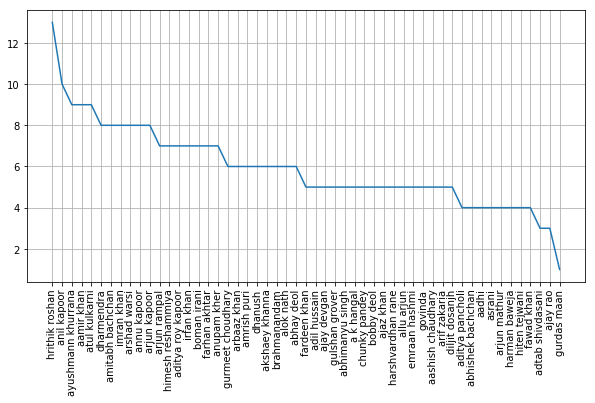

In [72]:
plt.figure(figsize=(10,5))
plt.plot(pd.Series(names).value_counts())
plt.xticks(rotation=90)
plt.grid(b=True)
plt.show()

In [0]:
alignment = AlignDlib('models/landmarks.dat')

In [0]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]
  
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [12]:
#Load pretrained Model

model = create_model()
model.load_weights('open_face.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    try:
      img = load_image(m.image_path())
      img = align_image(img)
      # scale RGB values to interval [0,1]
      img = (img / 255.).astype(np.float32)
      # obtain embedding vector for image
      embedded[i] = model.predict(np.expand_dims(img, axis=0))[0]
    except:
      print(i,m)

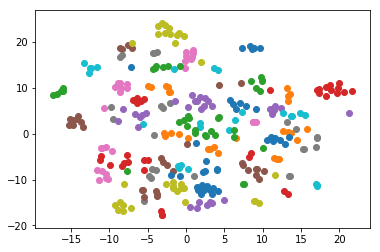

In [140]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(names)):
    idx = names == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   



In [0]:
df = pd.DataFrame(embedded)
df.to_csv("embedded_314_celeb.csv",index=False)

53

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
names_encode = le.fit_transform(names)

In [0]:
import pickle
with open('names_encode.pickle', 'wb') as f:
    pickle.dump(names_encode, f)

In [118]:
y = np.zeros((embedded.shape[0],len(set(names_encode))),dtype=int)
y.shape

(314, 53)

In [0]:
for i,name in enumerate(names):
  ind = names_encode[i]
  y[i][ind]=1

In [120]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [149]:
train_idx = np.arange(embedded.shape[0]) % 5 != 0
test_idx = np.arange(embedded.shape[0]) % 5 == 0

print(np.sum(train_idx))
print(np.sum(test_idx))

251
63


In [0]:
X_train = embedded[train_idx]
y_train = y[train_idx]

X_val = embedded[test_idx]
y_val = y[test_idx]

In [161]:
print(X_train.shape)
print(y_train.shape)

(251, 128)
(251, 53)


In [0]:
output_dim = 53
input_dim = X_train.shape[1]

batch_size = 8
nb_epoch = 250

In [0]:
import keras

In [165]:
model_relu = Sequential()

model_relu.add(Dense(250, activation='relu', input_shape=(input_dim,), kernel_initializer=keras.initializers.he_normal(seed=None)))
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.5))

model_relu.add(Dense(100, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=None)) )
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.5))

model_relu.add(Dense(output_dim,activation='softmax'))

print(model_relu.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 250)               32250     
_________________________________________________________________
batch_normalization_13 (Batc (None, 250)               1000      
_________________________________________________________________
dropout_13 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               25100     
_________________________________________________________________
batch_normalization_14 (Batc (None, 100)               400       
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 53)                5353      
Total para

In [0]:
model_relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [168]:
history = model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,validation_data=[X_val,y_val])

Train on 251 samples, validate on 63 samples
Epoch 1/250
251/251 [==============================] - 2s 9ms/step - loss: 4.9032 - acc: 0.0398 - val_loss: 3.6727 - val_acc: 0.0952
Epoch 2/250
251/251 [==============================] - 0s 910us/step - loss: 4.2614 - acc: 0.0876 - val_loss: 3.1072 - val_acc: 0.2063
Epoch 3/250
251/251 [==============================] - 0s 878us/step - loss: 3.6591 - acc: 0.1116 - val_loss: 2.6418 - val_acc: 0.3492
Epoch 4/250
251/251 [==============================] - 0s 914us/step - loss: 3.3038 - acc: 0.1594 - val_loss: 2.3508 - val_acc: 0.4921
Epoch 5/250
251/251 [==============================] - 0s 922us/step - loss: 2.8763 - acc: 0.2550 - val_loss: 2.0446 - val_acc: 0.4921
Epoch 6/250
251/251 [==============================] - 0s 889us/step - loss: 2.6010 - acc: 0.2829 - val_loss: 1.8422 - val_acc: 0.5873
Epoch 7/250
251/251 [==============================] - 0s 890us/step - loss: 2.3420 - acc: 0.3825 - val_loss: 1.7477 - val_acc: 0.6190
Epoch 8/250


In [128]:
# serialize model to JSON
model_json = model_relu.to_json()
with open("sequential_NN_314_model_output_53dim.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_relu.save_weights("sequential_NN_314_model_ouput_53dim.h5")

print("Saved model to disk")

Saved model to disk


PREDICTION

Original Query Image


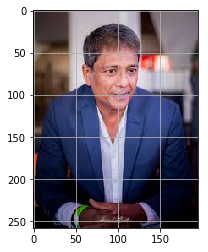

In [172]:
path = "download (6).jpg"
img = load_image(path)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [173]:
faces = alignment.getAllFaceBoundingBoxes(img)
faces

rectangles[[(73, 53) (135, 115)]]

In [176]:
for i in range(len(faces)):
  face_aligned = alignment.align(96, img, faces[i], landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
  face_aligned = (face_aligned / 255.).astype(np.float32)
  embedding = model.predict(np.expand_dims(face_aligned, axis=0))[0]
  pred = model_relu.predict([[embedding]])
  ind = np.argsort(pred[0])
  print(ind[::-1][:5])
  print(le.inverse_transform([ind[::-1][0]])[0])
  print("Prediction Probability: ",pred[0][ind[::-1][0]]*100,"%")
  print()

[ 7 23 32 29 42]
adil hussain
Prediction Probability:  79.6936571598053 %

